# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from scipy import stats

In [2]:
# Imputing, Encoding, Scaling, and Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

# Scoring and feature Selection
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.inspection import permutation_importance

# Models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

# Load Data

In [3]:
train = pd.read_csv('../raw_data/train.csv')
X_test = pd.read_csv('../raw_data/test.csv')

In [4]:
# Quick peek at the train + test sets and shapes

display(train.head(3))
display(X_test.head(3))
train.shape, X_test.shape

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


((8693, 14), (4277, 13))

In [5]:
# Copying train for EDA
eda_train = train.copy()

# Creating X_train and y_train to feed into the pipe, these will be left relatively untouched until modelling
X_train = train.drop(columns='Transported')
y_train = train['Transported']

In [6]:
X_train.shape, y_train.shape

((8693, 13), (8693,))

# EDA

## Summary
- Dimensions
- data-types
- Target balance
- duplicates
- missing values

In [7]:
# expanded form of pandas .info() to include shape, null count, null %, unique count
def infoplus(frame):
    infod = {'col_ind': [], 'col_name': [], 'non_null': [], 'null': [],
             'null_per': [], 'unique': [],'dtype': []}
    max_len = []

    for i, col in enumerate(frame.columns):
        infod['col_ind'].append(i)
        infod['col_name'].append(col)
        infod['non_null'].append(frame[col].value_counts().sum())
        infod['null'].append(frame[col].isna().sum())
        infod['null_per'].append(round(infod['null'][-1] / len(X_train), 5))
        infod['unique'].append(len(frame[col].unique()))
        infod['dtype'].append(str(frame[col].dtype))

    for key in infod.keys():
        max_len.append(len(max(map(str, infod[key]), key=len)))
    for i, key in enumerate(infod.keys()):
        max_len[i] = max(len(key), max_len[i])

    OFFSET = 1
    print(type(frame))
    print(f'Range Index: {len(frame)} entries, {frame.index[0]} to {frame.index[-1]}')
    print(f'Shape: {frame.shape}')
    print(f'''\
{'#': ^{max_len[0] + OFFSET}}\
{'Column': <{max_len[1] + OFFSET}}\
{'Non-Null': <{max_len[2] + OFFSET}}\
{'Null': >{max_len[3] + OFFSET}}\
{'% Null': >{max_len[4] + OFFSET}}\
{'Unique': >{max_len[5] + OFFSET}}  \
{'Dtype': <{max_len[6] + OFFSET}}\
''')
    print(f'''\
{'-' * (max(3, max_len[0] - 2)): ^{max_len[0] + OFFSET}}\
{'-' * max_len[1]: <{max_len[1] + OFFSET}}\
{'-' * max_len[2]: <{max_len[2] + OFFSET}}\
{'-' * max_len[3]: >{max_len[3] + OFFSET}}\
{'-' * max_len[4]: >{max_len[4] + OFFSET}}\
{'-' * max_len[5]: >{max_len[5] + OFFSET}}  \
{'-' * max_len[6]: <{max_len[6] + OFFSET}}\
''')
    for i in infod['col_ind']:
        print(f'''{str(infod['col_ind'][i]): ^{max(3, max_len[0] + OFFSET)}}\
{infod['col_name'][i]: <{max_len[1] + OFFSET}}\
{infod['non_null'][i]: <{max_len[2] + OFFSET}}\
{infod['null'][i]: >{max_len[3] + OFFSET}}\
{round(infod['null_per'][i] * 100, 2): >{max_len[4] + OFFSET}}\
{infod['unique'][i]: >{max_len[5] + OFFSET}}  \
{infod['dtype'][i]: <{max_len[6] + OFFSET}}\
              ''')
    
    dtypes = [dtype for dtype in set(infod['dtype'])]
    for dtype in dtypes:
        dtype_count = [f"{dtype}({infod['dtype'].count(dtype)})" for dtype in dtypes]
    print(f"dtypes: {', '.join(dtype_count)}")
    print(f'memory usage: {byte_conversion(frame.memory_usage().sum())}')
    
# Helper Function
def byte_conversion(frame_mem):
    ending_dict = {1: 'B', 2: 'KB', 3: 'MB', 4: 'GB'}
    power = 1
    while frame_mem / (1024 ** power) > 1:
        power += 1
        if power == 4:
            break
    return f'{round(frame_mem / (1024 ** (power - 1)), 2)} {ending_dict[power]}' 

In [8]:
# Dimensions, data types, missing values
# Custom Function similar to df.info(). 
# Feel free to copy or if you have feedback on efficiency leave me a comment

infoplus(eda_train)

<class 'pandas.core.frame.DataFrame'>
Range Index: 8693 entries, 0 to 8692
Shape: (8693, 14)
   #    Column       Non-Null  Null   % Null Unique  Dtype   
 -----  ------------ --------  ---- -------- ------  ------- 
   0    PassengerId  8693         0      0.0   8693  object                
   1    HomePlanet   8492       201     2.31      4  object                
   2    CryoSleep    8476       217      2.5      3  object                
   3    Cabin        8494       199     2.29   6561  object                
   4    Destination  8511       182     2.09      4  object                
   5    Age          8514       179     2.06     81  float64               
   6    VIP          8490       203     2.34      3  object                
   7    RoomService  8512       181     2.08   1274  float64               
   8    FoodCourt    8510       183      2.1   1508  float64               
   9    ShoppingMall 8485       208     2.39   1116  float64               
   10   Spa          85

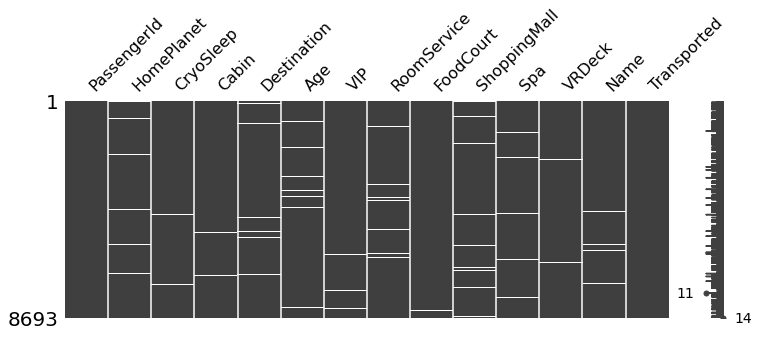

In [9]:
# taking a look at the Null spread to see if there looks like there is any relationships and if we can drop them

msno.matrix(df=eda_train, figsize=(12,4))
plt.show()

There's Null values in all features of the dataset. From the provided data description, they don't hold mearning and are genuinely missing values. 

They take up a small percentage of the total dataset and seem to be spread randomly throughout, we'll probably impute values for them later.

There are no Null values for the target.

In [10]:
# Check to see if there are duplicated rows

eda_train.duplicated().sum()

0

In [11]:
# Check balance of target to see if we need synthetic data or over/under sampling

print(f"Transported: {eda_train['Transported'].sum()}, Not Transported: {len(eda_train) - eda_train['Transported'].sum()}")

# Train set is balanced

Transported: 4378, Not Transported: 4315


A quick and dirty look at the features that numerical and categorical, this needs to be done in context with the given data descriptions

In [12]:
def quick_features(frame, colskip=[]):
    feats_cat = []
    feats_num = []

    for col in frame.columns:
        if col in colskip:
            continue
        elif frame[col].dtype == 'object' or frame[col].dtype == 'bool':
            feats_cat += [col]
        else:
            feats_num += [col]

    print(f'{len(feats_cat)} categorical features \t', feats_cat)
    print(f'{len(feats_num)} numerical features \t', feats_num)
    return (feats_cat, feats_num)

In [13]:
# Making sure to drop ID and target
DROP = ['PassengerId', 'Transported']

feat_cat, feat_num = quick_features(eda_train.drop(columns=DROP))

6 categorical features 	 ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name']
6 numerical features 	 ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


## Prelim feature engineering

Looking at the 'Cabin' feature in the data description, it contains three features: Deck, Level, and Side. Split these out and drop the original 'Cabin' feature

In [14]:
# Put this into a function for piping later
def cabin_transform(df):
    # Split into 3 features
    df[['Cabin_Deck', 'Cabin_Level', 'Cabin_Side']] = df['Cabin'].str.split('/', expand=True)
    # Drop original feature
    df.drop(columns='Cabin', inplace=True)
    # Cast Cabin_level from a string to a float (can't cast to int because of NaN's)
    df['Cabin_Level'] = pd.to_numeric(df['Cabin_Level'])
    return df

In [15]:
# A quick look at the new frame

cabin_transform(eda_train).head(3)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_Deck,Cabin_Level,Cabin_Side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S


In [16]:
infoplus(eda_train)

<class 'pandas.core.frame.DataFrame'>
Range Index: 8693 entries, 0 to 8692
Shape: (8693, 16)
   #    Column       Non-Null  Null   % Null Unique  Dtype   
 -----  ------------ --------  ---- -------- ------  ------- 
   0    PassengerId  8693         0      0.0   8693  object                
   1    HomePlanet   8492       201     2.31      4  object                
   2    CryoSleep    8476       217      2.5      3  object                
   3    Destination  8511       182     2.09      4  object                
   4    Age          8514       179     2.06     81  float64               
   5    VIP          8490       203     2.34      3  object                
   6    RoomService  8512       181     2.08   1274  float64               
   7    FoodCourt    8510       183      2.1   1508  float64               
   8    ShoppingMall 8485       208     2.39   1116  float64               
   9    Spa          8510       183      2.1   1328  float64               
   10   VRDeck       85

- Non-Null and Null counts match for 'Cabin_Deck', 'Cabin_Level', and 'Cabin_Side'
- All three new features are categorical

In [17]:
# Have a look at features again

feat_cat, feat_num = quick_features(eda_train.drop(columns=DROP))

7 categorical features 	 ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Name', 'Cabin_Deck', 'Cabin_Side']
7 numerical features 	 ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_Level']


In [18]:
# Adjust Cabin_Level

feat_cat.append(feat_num.pop(feat_num.index('Cabin_Level')))

display(feat_cat)
display(feat_num)

['HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP',
 'Name',
 'Cabin_Deck',
 'Cabin_Side',
 'Cabin_Level']

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Univariate Analysis

## Numerical Features
- Mean, median, mode
- Variance, IQR, outliers
- Correlation

In [19]:
eda_train[feat_num].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


looks like there are some outliers

Bach to outliers, visualising:

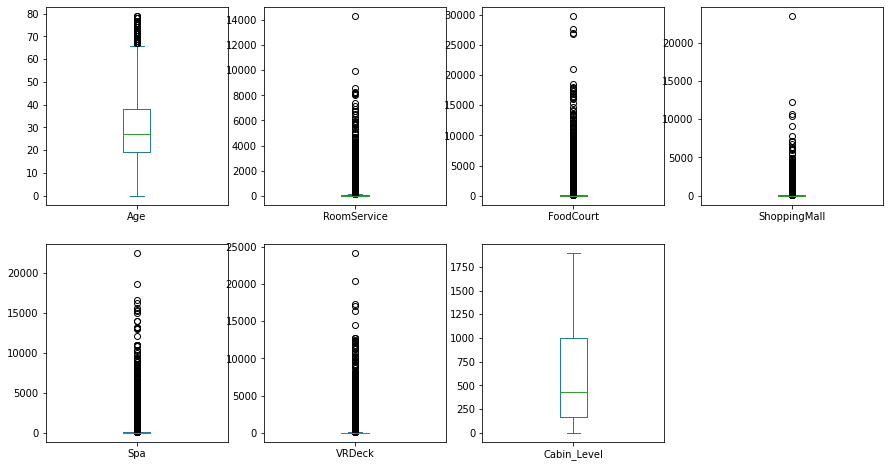

In [20]:
eda_train.plot(kind='box',subplots=True,layout=(2,4),sharex=False,sharey=False,figsize=(15,8))
plt.show()

Outliers confirmed

See if any features are correlated

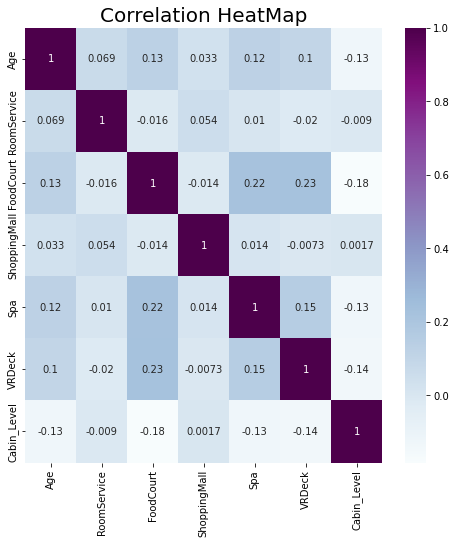

In [21]:
plt.figure(figsize=(8, 8))
sns.heatmap(eda_train.drop(columns=DROP).corr(), cmap='BuPu', annot=True)
plt.title('Correlation HeatMap', fontsize=20)
plt.show()

Not really, spending (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck) are somewhat correlated to CryoSleep, which intuitively makes sense.

Pairplot to see if there are any linear relationships between features

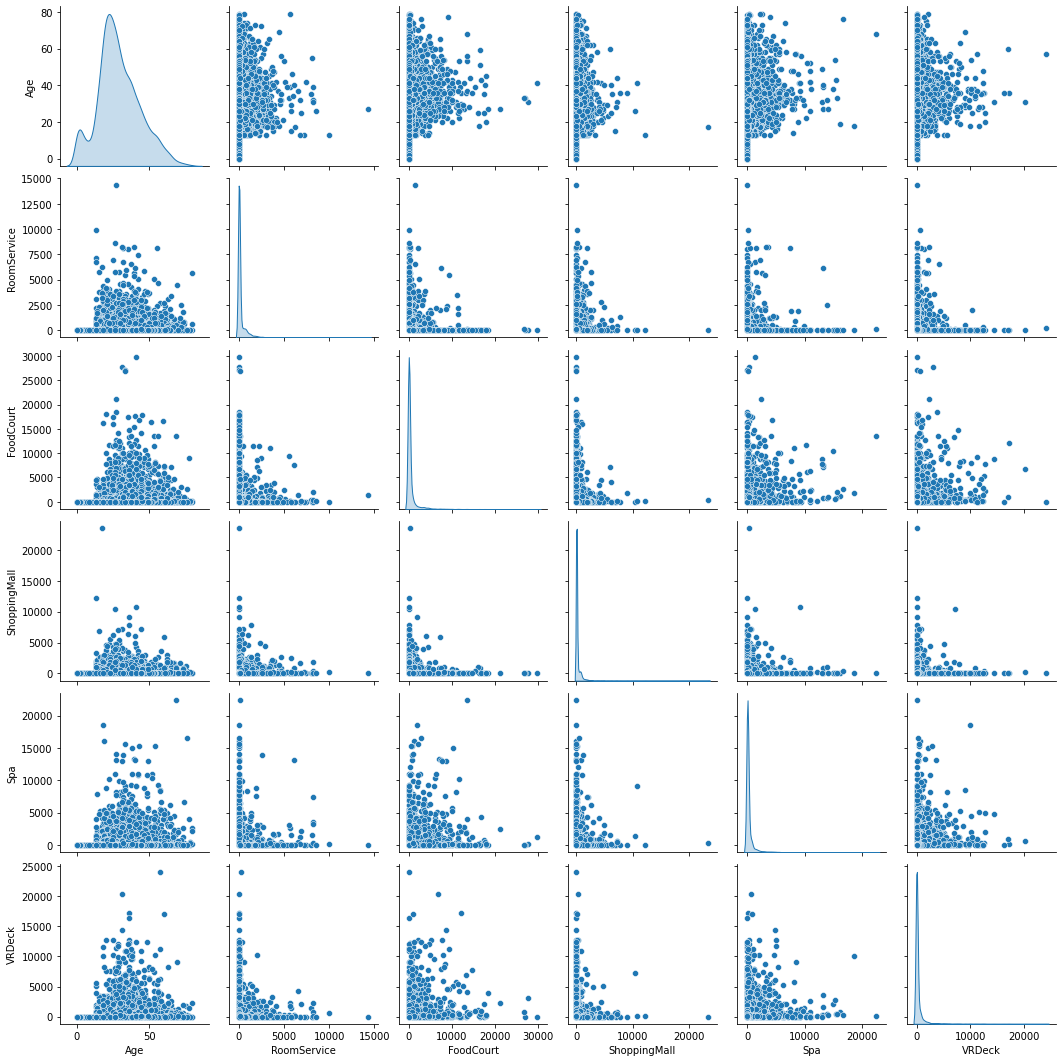

In [22]:
sns.pairplot(data=eda_train, vars=feat_num, diag_kind='kde')
plt.show()

No obvious linear relationships

Distributions of each feature (Diagonal plots on the pairplot)

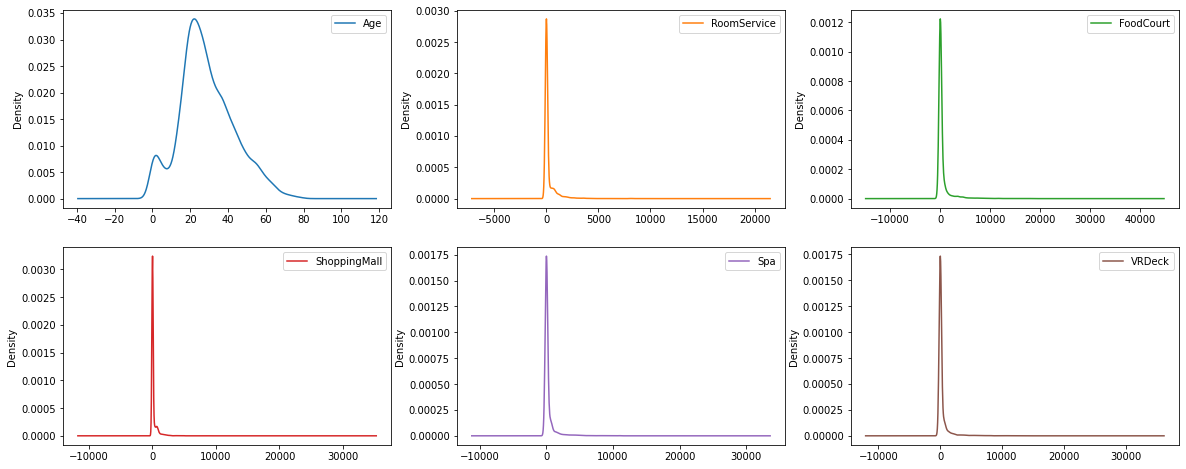

In [23]:
eda_train[feat_num].plot(kind='kde',subplots=True,layout=((len(feat_num) -1) // 3 + 1,3),sharex=False,sharey=False,figsize=(20,8))
plt.show()

Again, many outliers. The only feature that is remotely close to being normally distributed is age which is bi-modal. The rest are highly skewed.

In [24]:
# Skewness of numerical features

eda_train[feat_num].skew(skipna=True).sort_values(ascending=False)

ShoppingMall    12.627562
VRDeck           7.819732
Spa              7.636020
FoodCourt        7.102228
RoomService      6.333014
Age              0.419097
dtype: float64

## Categorical Features

In [25]:
eda_train[feat_cat].describe(include=['object', 'bool'])

,HomePlanet,CryoSleep,Destination,VIP,Name,Cabin_Deck,Cabin_Side
count,8492,8476,8511,8490,8493,8494,8494
unique,3,2,3,2,8473,8,2
top,Earth,False,TRAPPIST-1e,False,Gollux Reedall,F,S
freq,4602,5439,5915,8291,2,2794,4288


In [26]:
# Countplot
feat_cat_uni = feat_cat
feat_cat_uni.remove('Name')
feat_cat_uni.remove('Cabin_Level')
print(feat_cat_uni)

['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side']


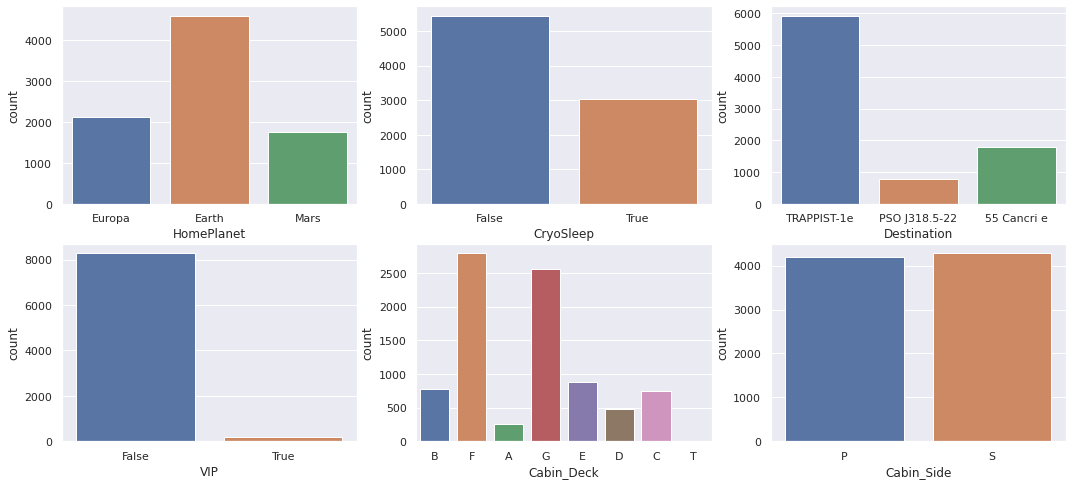

In [27]:
sns.set(rc={'figure.figsize':(18,8)})
fig, axes = plt.subplots((len(feat_cat_uni) -1) // 3 + 1, 3)

for col, ax in zip(feat_cat_uni, axes.flatten()):
    sns.countplot(x=col, data=eda_train[feat_cat_uni], ax=ax)

There are almost no VIP's (less than the number of null values in the feature), could be dropped

In [28]:
eda_train['VIP'].sum(), eda_train['VIP'].isna().sum()

(199, 203)

# Bivariate Analysis
With respect to the target: 'Transported'

## Numerical

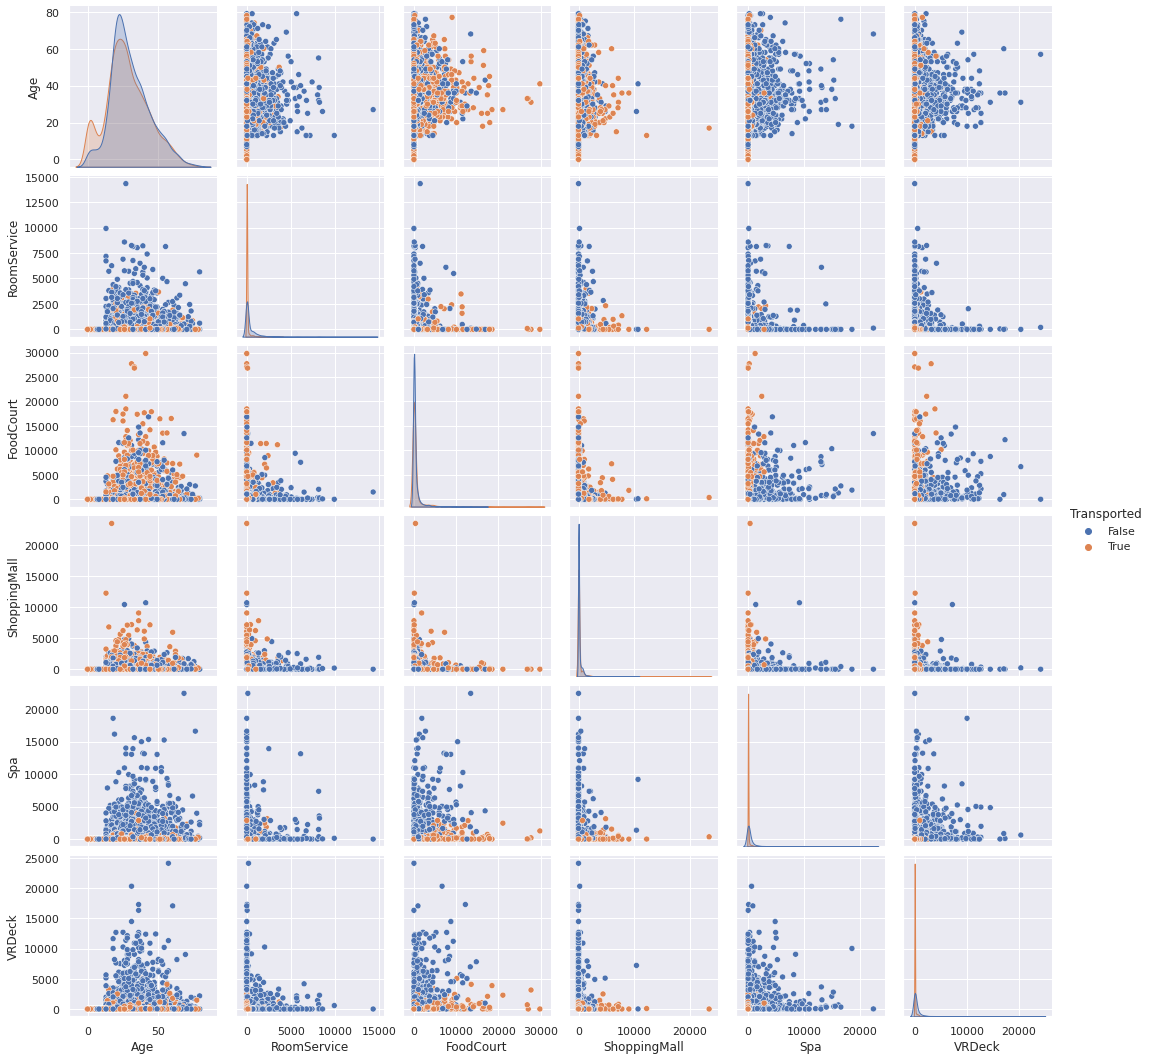

In [29]:
sns.pairplot(data=eda_train, vars=feat_num, hue='Transported', diag_kind='kde')
plt.show()

Again, doesn't look like there are any linear relationships

Looking at bivariate distributions

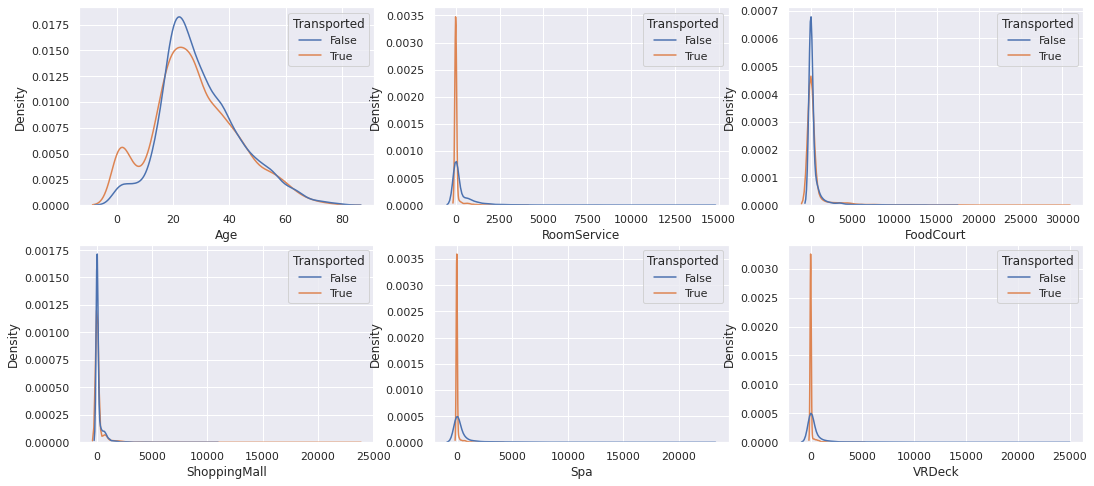

In [30]:
fig, axes = plt.subplots((len(feat_num) -1) // 3 + 1, 3,figsize=(18,8))

for col, ax in zip(feat_num, axes.flatten()):
    sns.kdeplot(x=col, data=eda_train, hue='Transported', ax=ax)

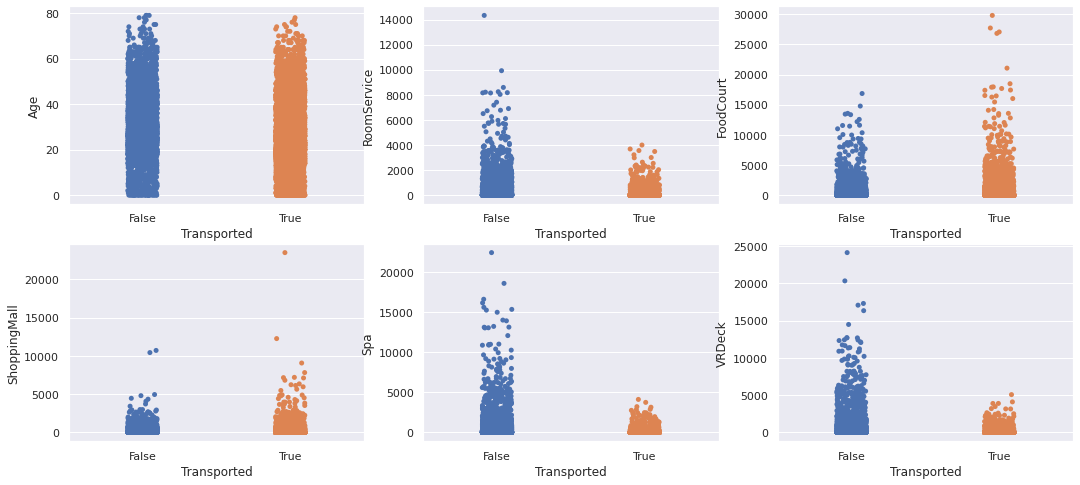

In [31]:
fig, axes = plt.subplots((len(feat_num) -1) // 3 + 1, 3,figsize=(18,8))

for col, ax in zip(feat_num, axes.flatten()):
    sns.stripplot(x='Transported', y=col, data=eda_train, ax=ax)

Observations:
- Children (~0-10) have a higher chance of being transported
    - This becomes magnified for young children (~0-5)
- Adults ~20-40 had a slightly lower chance of being transported
- People who spent more on RoomService, Spa and VRDec had a lower chance of being transported
- Shopping spending doesn't seem to be informative

## Categorical

I like bar charts

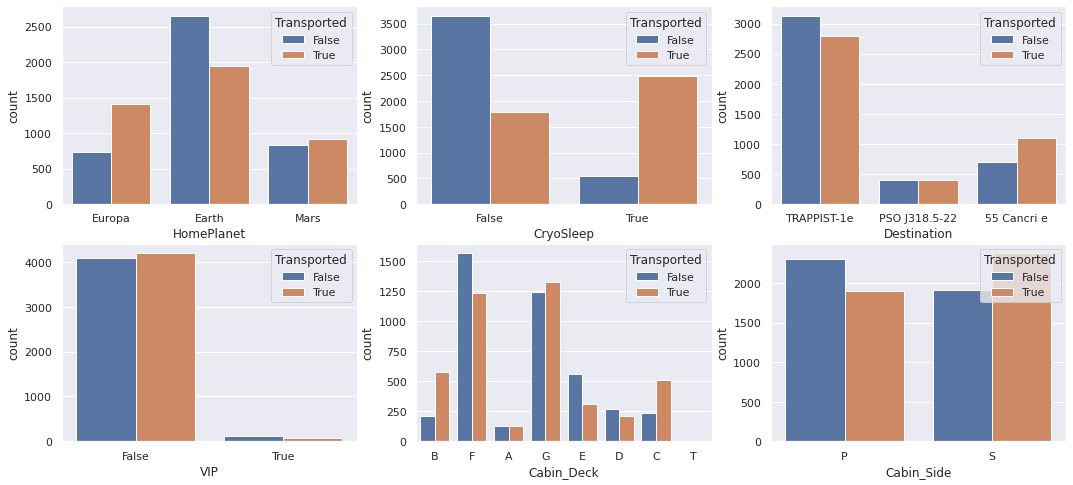

In [32]:
fig, axes = plt.subplots((len(feat_cat_uni) -1) // 3 + 1, 3,figsize=(18,8))

for col, ax in zip(feat_cat_uni, axes.flatten()):
    sns.countplot(x=col, hue='Transported', data=eda_train, ax=ax)

Some observations:
- People in CryoSleep are where more likely to be transported
- People heading to 55 Cancri e had where more likely to be transported and people heading to TRAPPIST-1e where less likely to be transported, it appears even for people heading to PSO J318.5-22
- People staying on the starboard side where more likely to be transported
- People from Europa where more likely to be transported and people from Earth less likely, appears even for people from Mars
- I don't think that there is enough data to comment on VIP's

# Pipeline

## Dropping unused columns

Drop PassengerId and Names. 

More feature engineering can be done to be made into features such as:
- if a passenger is in a group 
- if a passenger has family
- if a passenger shares a first name with another passenger

In [33]:
def drop_columns(frame):
    return frame.drop(columns=['PassengerId', 'Name'])

In [34]:
drop_col = FunctionTransformer(drop_columns)

In [35]:
# Testing
drop_col.transform(X_train).head(3)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0


## Splitting Cabin into Cabin_Deck, Cabin_Level, and Cabin_Side

In [36]:
cabin_trans = FunctionTransformer(cabin_transform) 

In [37]:
# testing
cabin_trans.transform(drop_col.transform(X_train)).head(3)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Cabin_Level,Cabin_Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,F,0.0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,A,0.0,S


## Missing values

Missing Values: there is ~2-2.5% of values missing per feature, collectively this is 25% of the dataset if every row with a missing value was dropped.

Because of the relatively low % per feature, we'll impute numerical values with the median (more resistant to outliers than mean) and categorical features with mode.

In [38]:
print(f'{round(1 - (len(eda_train.dropna()) / len(eda_train)), 4) * 100}% rows with 1 or more null value')

24.01% rows with 1 or more null value


In [39]:
median_imp = SimpleImputer(strategy='median')
mode_imp = SimpleImputer(strategy='most_frequent')

## Outliers and Scaling

Scaling is required for distance based algoriths like KNN and SVM, and so that one feature isn't more prominent because it's scale is magnitudes higher than another feature.

Numerical columns have hefty outliers. Scale numerical features with RobustScaler().
Could also manually scale outliers so that they are constricted by 1st or 3rd IQR

Also going to scale ordinal categorical features between 0 and 1

In [40]:
r_scaler = RobustScaler()

mm_scaler = MinMaxScaler()

## Encoding

Some categorical features need encoding to be able to be interpreted by the algorithm. 

HomePlanet and Destination will be one hot encoded

CryoSleep, VIP, Cabin_Deck, Cabin_Side, and Cabin_Level will be ordinally encoded. CryoSleep, VIP, CabinSide are binaries, Cabin_Deck and Cabin_Level have the same relative distance between them (except Deck T, which I'm going to ignore because it has 5 data points).

In [41]:
len(eda_train[eda_train['Cabin_Deck'] == 'T'])

5

In [42]:
ohe_enc = OneHotEncoder(sparse=False)
ord_enc = OrdinalEncoder()

## Assembling Pipe

Dropping the columns and making Cabin into three separate features can be piped together

In [43]:
preproc_1 = Pipeline([
    ('drop_col', drop_col),
    ('cabin_transform', cabin_trans)
])

preproc_1

Pipeline(steps=[('drop_col',
                 FunctionTransformer(func=<function drop_columns at 0x7fc9c675c550>)),
                ('cabin_transform',
                 FunctionTransformer(func=<function cabin_transform at 0x7fc9cb755670>))])

Encoding and scaling need to be done in parallel after dropping columns and transforming 'Cabin'

Current features:

- FEAT_NUM = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
- FEAT_CAT = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side']
    - of which:
    - FEAT_OHE = ['HomePlanet', 'Destination']
    - FEAT_ORD = ['CryoSleep', 'VIP', 'Cabin_Deck', 'Cabin_Level', 'Cabin_Side']

In [44]:
FEAT_NUM = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
FEAT_OHE = ['HomePlanet', 'Destination']
FEAT_ORD = ['CryoSleep', 'VIP', 'Cabin_Deck', 'Cabin_Side', 'Cabin_Level']

In [45]:
FEAT_ORD[:-1]

['CryoSleep', 'VIP', 'Cabin_Deck', 'Cabin_Side']

In [46]:
# Create 4 separate pipes for num, ohe, ord_alpha and ord_numeric
# Could put a column transformer into the ord pipe but it's annoying

# Numerical Pipe
trans_num = Pipeline([
    ('median_imputer', median_imp),
    ('robust_scaler', r_scaler)
])

# OHE Pipe
trans_ohe = Pipeline([
    ('mode_imputer', mode_imp),
    ('ohe', ohe_enc)
])

# Ord_alpha Pipe
trans_ordalpha = Pipeline([
    ('mode_imputer', mode_imp),
    ('ord_encoder', ord_enc),
    ('minmax_scaler', mm_scaler)
])

# Ord_num Pipe
trans_ordnum = Pipeline([
    ('mode_imputer', mode_imp),
    ('minmax_scaler', mm_scaler)
])

# All three in parallel
preproc_2 = ColumnTransformer([
    ('trans_num', trans_num, FEAT_NUM),
    ('trans_ohe', trans_ohe, FEAT_OHE),
    ('trans_ordalpha', trans_ordalpha, FEAT_ORD[:-1]),
    ('scale_ordnum', trans_ordnum, [FEAT_ORD[-1]])
])

preproc_2

ColumnTransformer(transformers=[('trans_num',
                                 Pipeline(steps=[('median_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('robust_scaler',
                                                  RobustScaler())]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck']),
                                ('trans_ohe',
                                 Pipeline(steps=[('mode_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(sparse=False))]),
                                 ['HomePlanet'...),
                                ('trans_ordalpha',
                                 Pipeline(steps=[('mode_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord_encoder',
                                                  OrdinalEncoder()),
                                                 ('minmax_scaler',
                                                  MinMaxScaler())]),
                                 ['CryoSleep', 'VIP', 'Cabin_Deck',
                                  'Cabin_Side']),
                                ('scale_ordnum',
                                 Pipeline(steps=[('mode_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmax_scaler',
                                                  MinMaxScaler())]),
                                 ['Cabin_Level'])])

In [47]:
# full preprocessing pipe
preproc = Pipeline([
    ('drop_create', preproc_1),
    ('enc_scaling', preproc_2)
])

preproc

Pipeline(steps=[('drop_create',
                 Pipeline(steps=[('drop_col',
                                  FunctionTransformer(func=<function drop_columns at 0x7fc9c675c550>)),
                                 ('cabin_transform',
                                  FunctionTransformer(func=<function cabin_transform at 0x7fc9cb755670>))])),
                ('enc_scaling',
                 ColumnTransformer(transformers=[('trans_num',
                                                  Pipeline(steps=[('median_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robu...
                                                 ('trans_ordalpha',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord_encoder',
                                                                   OrdinalEncoder()),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['CryoSleep', 'VIP',
                                                   'Cabin_Deck',
                                                   'Cabin_Side']),
                                                 ('scale_ordnum',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Cabin_Level'])]))])

In [48]:
# Testing
pd.DataFrame(preproc.fit_transform(X_train), columns=preproc[-1].get_feature_names_out()).head(3)

,trans_num__Age,trans_num__RoomService,trans_num__FoodCourt,trans_num__ShoppingMall,trans_num__Spa,trans_num__VRDeck,trans_ohe__HomePlanet_Earth,trans_ohe__HomePlanet_Europa,trans_ohe__HomePlanet_Mars,trans_ohe__Destination_55 Cancri e,trans_ohe__Destination_PSO J318.5-22,trans_ohe__Destination_TRAPPIST-1e,trans_ordalpha__CryoSleep,trans_ordalpha__VIP,trans_ordalpha__Cabin_Deck,trans_ordalpha__Cabin_Side,scale_ordnum__Cabin_Level
0,0.705882,0.000000,0.000000,0.000000,0.000000,0.000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.142857,0.0,0.0
1,-0.176471,2.658537,0.147541,1.136364,10.358491,1.100,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.714286,1.0,0.0
2,1.823529,1.048780,58.622951,0.000000,126.698113,1.225,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,1.0,0.0


Look below for using sklearns make_pipeline and make_column_transformer syntax. 

In [49]:
# Using sklearn make_pipeline and make_column_transformer

# preproc_1 - dropping columns and cabin transform
make_preproc_1 = make_pipeline(drop_col, cabin_trans)

# preproc_2 - imputing, encoding, and scaling
num_transform = make_pipeline(median_imp, r_scaler)
cat_transform = make_pipeline(mode_imp, ohe_enc)
ordalpha_transform = make_pipeline(mode_imp, ord_enc, mm_scaler)
ordnum_transform = make_pipeline(mode_imp, mm_scaler)

make_preproc_part2 = make_column_transformer(
    (num_transform, FEAT_NUM), 
    (cat_transform, FEAT_OHE),
    (ordalpha_transform, FEAT_ORD[:-1]),
    (ordnum_transform, [FEAT_ORD[-1]])
    )

# preproc - assembly
make_preproc = make_pipeline(preproc_1, preproc_2)

# the two pipes are the same
np.array_equal(preproc.fit_transform(X_train), make_preproc.fit_transform(X_train))

True

# Models

Some different classification models:
- Logistic
- Support Vector
    - rbf
    - linear
    - sigmoid
- KNN
- Random Forest
- Gradient Boosted Random Trees

In [50]:
log_model = LogisticRegression(max_iter=1000)
svc_rbf = SVC(kernel='rbf', probability=True)
svc_lin = SVC(kernel='linear')
svc_sig = SVC(kernel='sigmoid')
knn_cla = KNeighborsClassifier(n_neighbors=10)
rnf_ens = RandomForestClassifier()
gbm_ens = GradientBoostingClassifier()

prelim_models = [log_model, svc_rbf, svc_lin, svc_sig, knn_cla, rnf_ens, gbm_ens]

In [51]:
# initial scoring without hyper-parameter tuning - will take a while
cv_dict = {}
for model in prelim_models:
    pipe = make_pipeline(preproc, model)
    cv_score = cross_validate(pipe, X_train, y_train, cv=5, scoring='accuracy')['test_score']
    cv_dict[model] = round(cv_score.mean(), 3)

In [52]:
cv_dict

{LogisticRegression(max_iter=1000): 0.784,
 SVC(probability=True): 0.789,
 SVC(kernel='linear'): 0.787,
 SVC(kernel='sigmoid'): 0.713,
 KNeighborsClassifier(n_neighbors=10): 0.785,
 RandomForestClassifier(): 0.785,
 GradientBoostingClassifier(): 0.787}

rbf and linear SVC, KNN, RF and GBM all do alright. 

GBM is a type of Random Forest and SVC with a RBF kernel performed betted than the linear kernel, so drop linear and sigmoid SVC, Logistic Classifier, and Random Forest Classifier.

In [53]:
# need grid search params for rbf_svc, knn_cla, and gbm_ens

svc_rbf_params = {
    # 'svc__C': [40, 45, 50, 55, 60]
    'svc__C': [35, 40, 45]
}

knn_cla_params = {
    'kneighborsclassifier__n_neighbors' : [18, 19, 20, 21, 22]),
}

gbm_ens_params = {
    # 'gradientboostingclassifier__criterion': ['friedman_mse', 'squared_error'],
    'gradientboostingclassifier__min_samples_split': [2, 3, 4, 5],
    'gradientboostingclassifier__min_samples_leaf': [1, 2, 3, 4, 5],
    'gradientboostingclassifier__max_depth': [3, 4, 5, 6, 7]
}

# GradientBoostingClassifier()

In [54]:
# put it all in a dictionary for easy access

models_dict = {'rbf_svc': 
          {
              'model': svc_rbf,
              'params': svc_rbf_params,
              'best_score': None,
              'best_params': None,
              'best_estimator': None
          },
          'knn_cla':
          {
              'model': knn_cla,
              'params': knn_cla_params,
              'best_score': None,
              'best_params': None,
              'best_estimator': None
          },
          'gbm_ens':
          {
              'model': gbm_ens,
              'params': gbm_ens_params,
              'best_score': None,
              'best_params': None,
              'best_estimator': None
          }
         }

In [ ]:
# This takes a while
for model in models_dict.values():
    search = GridSearchCV(make_pipeline(preproc, model['model']), 
                          model['params'], 
                          cv=5, 
                          scoring='accuracy',
                         n_jobs=1)
    search.fit(X_train, y_train)
    model['best_score'] = search.best_score_
    model['best_params'] = search.best_params_
    model['best_estimator'] = search.best_estimator_

In [ ]:
for model in models_dict.values():
    print(model['best_score'])
    print(model['best_params'])

## Voting Classifier

In [ ]:
best_models = [model['best_estimator'] for model in models_dict.values()]

In [ ]:
voting_classifier = VotingClassifier(estimators=best_models,
                                     voting='soft',
                                     weights=[1,1,1])

final_pipe = make_pipeline(preproc, voting_classifier)
final_pipe

In [ ]:
vc_score = cross_validate(final_pipe,
                          X_train,
                          y_train,
                          cv=5,
                          scoring='accuracy')
vc_score['test_score'].mean()

In [ ]:
final_pipe.fit(X_train, y_train)
predictions = final_pipe.predict(X_test)

In [ ]:
results = pd.concat([X_test['PassengerId'], pd.Series(predictions, name='Transported')], axis=1)

In [ ]:
results.shape

In [ ]:
# results.to_csv('spaceship-titanic-results-20220716.csv', header=True, index=False)